In [1]:
import numpy as np
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
#from tensorflow.examples.tutorials.mnist import input_data
from torch.autograd import Variable
import sklearn.metrics as metrics
import pickle
import os
import numpy.linalg as la
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from matplotlib import pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=True, download= True,
                       transform = transform)
test_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=False, download=True,
                       transform = transform)

In [3]:
batch_size = 96

In [4]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True)
print len(train_loader), len(test_loader)

625 105


In [5]:
ip_dim = 28*28
z_dim = 2
comb_dim = ip_dim + z_dim

#### Implementing BIGan

#### Encoder

In [6]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder,self).__init__()
        self.l1 = nn.Linear(ip_dim,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,500)
        self.l4 = nn.Linear(500,z_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = (self.l4(x))
        
        return x

### Decoder

In [7]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder,self).__init__()
        self.l1 = nn.Linear(z_dim,500)
        self.l2 = nn.Linear(500,500)
        self.l3 = nn.Linear(500,500)
        self.l4 = nn.Linear(500,ip_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.tanh(self.l4(x))
        
        return x

###  Discriminator

In [8]:
class disc(nn.Module):
    def __init__(self):
        super(disc,self).__init__()
        self.l1 = nn.Linear(comb_dim,100)
        #self.l2 = nn.Linear(100,100)
        self.l3 = nn.Linear(100,100)
        self.l4 = nn.Linear(50,1)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        #x = F.leaky_relu(self.l2(x))
        x = F.sigmoid(self.l3(x))
        
        return x

In [9]:
G = decoder().cuda()
E = encoder().cuda()
D = disc().cuda()

In [10]:
def clear_grad():
    G.zero_grad()
    E.zero_grad()
    D.zero_grad()

In [11]:
E_solver = optim.Adam(E.parameters(),lr = 1e-3)
G_solver = optim.Adam(G.parameters(),lr = 1e-3)
D_solver = optim.Adam(D.parameters(),lr = 1e-3)

In [12]:
CUDA_LAUNCH_BLOCKING=1

### Start with trained encoder and decoder

In [ ]:
epochs = 20
for ep in range(epochs):
    for idx,(x,label) in enumerate(train_loader):
        
        x = Variable(x.cuda())
        x = x.view(batch_size,28*28)
        z = Variable(torch.randn(batch_size,z_dim)).cuda()
        
        xhat = G(z)
        g_loss = nn.MSELoss()(xhat,x)
        g_loss.backward()
        
        G_solver.step()
        clear_grad()
        
    print g_loss.data[0]

0.264190167189
0.273378163576
0.268315166235
0.269947379827
0.26337826252
0.279199659824
0.279881894588
0.270196706057
0.256794691086
0.267131507397
0.270385086536
0.262193977833
0.267604082823
0.276733875275
0.264953523874
0.27368414402
0.277469605207
0.263889610767
0.28226056695
0.27723684907


(0.11249224096536636, 0.25438830256462097, 6.0740461349487305)


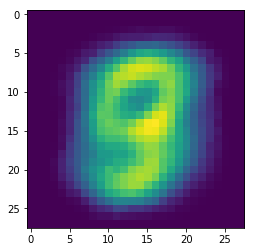

(0.11249224096536636, 0.2295258641242981, 5.653641700744629)
(0.06646154075860977, 0.2570957541465759, 8.00648021697998)
(0.06646154075860977, 0.25103798508644104, 8.833061218261719)
(0.009607282467186451, 0.25920313596725464, 10.02531909942627)
(0.009607282467186451, 0.26924237608909607, 9.609006881713867)


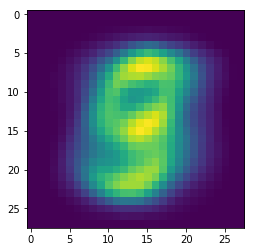

(0.005327985621988773, 0.2594834268093109, 11.264296531677246)
(0.005327985621988773, 0.2556270658969879, 11.542417526245117)
(0.001022393349558115, 0.2589585781097412, 12.625635147094727)
(0.001022393349558115, 0.2511189877986908, 12.282560348510742)
(0.0007320140721276402, 0.2561056911945343, 12.3269681930542)


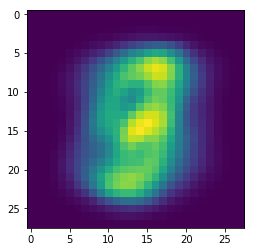

(0.0007320140721276402, 0.25083160400390625, 12.635171890258789)
(0.00019396409334149212, 0.2510967552661896, 14.161690711975098)
(0.00019396409334149212, 0.25590386986732483, 13.598453521728516)
(0.001679512090049684, 0.2601169943809509, 13.922867774963379)
(0.001679512090049684, 0.27242836356163025, 14.196399688720703)


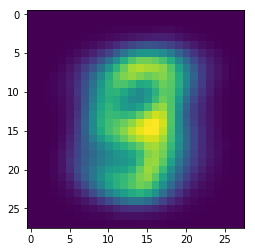

(0.0006256606429815292, 0.269420325756073, 15.114225387573242)
(0.0006256606429815292, 0.24848923087120056, 13.153082847595215)
(0.0018787030130624771, 0.24825723469257355, 12.132001876831055)
(0.0018787030130624771, 0.251175194978714, 12.431222915649414)
(0.00019364409672562033, 0.2755682170391083, 15.590688705444336)


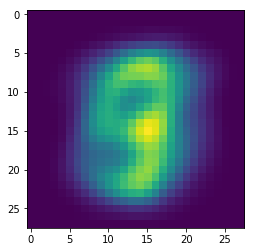

(0.00019364409672562033, 0.256188303232193, 15.013006210327148)
(0.0003073103434871882, 0.2626214027404785, 16.997066497802734)
(0.0003073103434871882, 0.25190839171409607, 17.466381072998047)
(3.787852983805351e-05, 0.2602774500846863, 18.74114227294922)
(3.787852983805351e-05, 0.2576138377189636, 17.773395538330078)


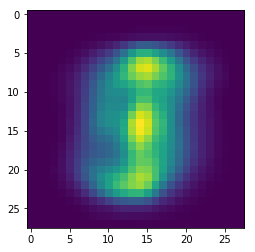

(0.0005525704473257065, 0.27837565541267395, 15.063091278076172)
(0.0005525704473257065, 0.2724636495113373, 14.977041244506836)
(0.003776882542297244, 0.27140092849731445, 18.40449333190918)
(0.003776882542297244, 0.25525200366973877, 17.90961456298828)
(0.0006079221493564546, 0.2446994185447693, 17.6215763092041)


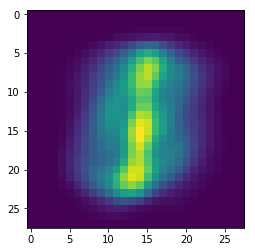

(0.0006079221493564546, 0.2654237151145935, 17.667741775512695)
(5.287163003231399e-05, 0.2542855441570282, 18.358327865600586)
(5.287163003231399e-05, 0.2542916536331177, 17.99306297302246)
(0.00010183084668824449, 0.2509602904319763, 16.469852447509766)
(0.00010183084668824449, 0.2579752206802368, 16.480682373046875)


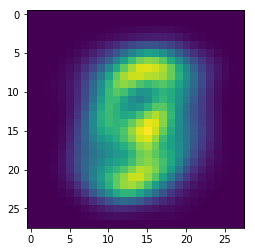

(0.0005077955429442227, 0.2633460462093353, 21.05295181274414)
(0.0005077955429442227, 0.2538423240184784, 21.332246780395508)
(8.364074165001512e-05, 0.2659224569797516, 15.361452102661133)
(8.364074165001512e-05, 0.2587413489818573, 15.865241050720215)
(2.7949885406997055e-05, 0.25251299142837524, 19.075963973999023)


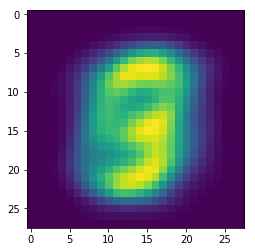

(2.7949885406997055e-05, 0.24873897433280945, 18.43409538269043)
(0.00012688073911704123, 0.24289388954639435, 17.04869270324707)
(0.00012688073911704123, 0.2680184543132782, 17.295692443847656)
(5.271242844173685e-05, 0.2490117847919464, 20.232757568359375)


In [ ]:
epochs = 100
for ep in range(epochs):
    for i,(x,label) in enumerate(train_loader):
        
        x = Variable(x.cuda())
        x = x.view(batch_size,28*28)
    
        
        z = Variable(torch.randn(batch_size,z_dim)).cuda()
        
        zhat = E(x)
        xhat = G(zhat)
        
        
       
        add_tiny = 1e-10        

        
#         t_label = Variable(torch.ones(d_true.size()).cuda())
#         f_label = Variable(torch.zeros(d_true.size()).cuda())
        
        ## autoencoder loss ##
        
        gen_loss = nn.MSELoss()(xhat,x)
        gen_loss.backward(retain_graph= True)
        G_solver.step()
        E_solver.step()
        clear_grad()
        
        ## Encoder has to fool the disc ##
        
        zhat = E(x)
        v1 = torch.cat([x,zhat],1)
        d_false = D(v1)
        enc_loss = -torch.mean(torch.log(d_false + add_tiny))
        enc_loss.backward(retain_graph= True)
        E_solver.step()
        clear_grad()
        
        ## Discriminator loss ##
        
       
        
        if(ep%2==0):
           
            zhat = E(x)
            v1 = torch.cat([x,zhat],1)
            v2 = torch.cat([xhat,z],1)
            
            d_false = D(v1)
            d_true = D(v2)            
            
            disc_loss = -torch.mean(torch.log(d_true + add_tiny) + torch.log((1-d_false) + add_tiny))
            disc_loss.backward()
            D_solver.step()
            clear_grad()       
   
        ### Updating the generator and the encoder ###
        
       
        
       
        
    
    if(ep%1==0):
        print(disc_loss.data[0],gen_loss.data[0],enc_loss.data[0])
        
    if(ep%5==0):
        z_check = Variable(torch.randn(1,z_dim)).cuda()
        op = G(z_check).resize(28,28)
        op = op.data.cpu().numpy()
        plt.imshow(op)
        plt.show()
        
            
        
        
        
        

###  Check

In [ ]:
z_check = Variable(torch.randn(1,z_dim)).cuda()
op = G(z_check)
op = op.resize(28,28)
op = op.data.cpu().numpy()
plt.imshow(op)
plt.show()

In [ ]:
print torch.min(x),torch.max(x)